# Standalone Modelfitting Dev

In [1]:
import os
import time
################################################################################
# Helper functions that expose some internal Brian machinery
def initialize_parameter(variableview, value):
    variable = variableview.variable
    array_name = device.get_array_name(variable)
    static_array_name = device.static_array(array_name, value)
    device.main_queue.append(('set_by_array', (array_name,
                                               static_array_name,
                                               False)))
    return static_array_name


def set_parameter_value(identifier, value):
    print(identifier)
    np.atleast_1d(value).tofile(os.path.join(device.project_dir,
                                             'static_arrays',
                                             identifier))

def run_again():
    device.run(device.project_dir, with_output=False, run_args=[])

In [2]:
from brian2 import set_device, device

In [3]:
from brian2 import *
set_device('cpp_standalone', directory='parallel', clean=False)


In [4]:
# num_neurons = 500
# duration = 2*second

# # Parameters
# area = 20000*umetre**2
# Cm = 1*ufarad*cm**-2 * area
# gl = 5e-5*siemens*cm**-2 * area
# El = -65*mV
# EK = -90*mV
# ENa = 50*mV
# g_na = 100*msiemens*cm**-2 * area
# g_kd = 30*msiemens*cm**-2 * area
# VT = -63*mV

# # The model
# eqs = Equations('''
# dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
# dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
#     (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
#     (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
# dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
#     (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
# dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
# I : amp
# ''')
# # Threshold and refractoriness are only used for spike counting
# group = NeuronGroup(num_neurons, eqs,
#                     threshold='v > -40*mV',
#                     refractory='v > -40*mV',
#                     method='exponential_euler', name='neurongroup')
# group.v = El
# param_I = initialize_parameter(group.I, np.zeros(num_neurons))

# monitor = SpikeMonitor(group, name='spikemonitor')
# run(duration)

In [5]:
# # Run it again
# start = time.time()
# set_parameter_value(param_I, 0.7*nA *np.arange(num_neurons) / num_neurons)
# run_again()
# print('Took: {:.3f}s'.format(time.time() - start))

In [6]:
# 0.7*nA *np.arange(num_neurons) / num_neurons

## Example with Parameters and Input Traces to be set

In [7]:
start_scope()

In [8]:
from brian2 import *
set_device('cpp_standalone', directory='parallel', clean=False)

In [9]:
input_traces = zeros((10,5))*volt
for i in range(5):
    input_traces[5:,i]=i*10*mV

output_traces = 10*nS*input_traces

In [10]:
input_traces

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0., 10., 20., 30., 40.],
       [ 0., 10., 20., 30., 40.],
       [ 0., 10., 20., 30., 40.],
       [ 0., 10., 20., 30., 40.],
       [ 0., 10., 20., 30., 40.]]) * mvolt

In [11]:
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV

In [12]:
# Generate a step-current input and an "experimental" voltage trace
dt = 0.01*ms
input_current = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*nA

In [13]:
input_current = np.concatenate([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))]) * nA


In [14]:
x = np.concatenate([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])
y = np.concatenate([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt))*2, np.zeros(int(5*ms/dt))])

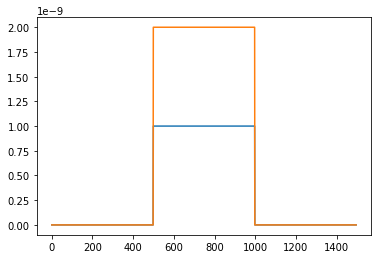

In [15]:
input_current2 = np.stack((x, y)).transpose() *nA
plot(input_current2)
# plot(input_current2[0])
# plot(input_current2[1]);

In [16]:
# input_current2

In [17]:
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

defaultclock.dt = dt
I = TimedArray(input_current, dt=dt)

In [18]:
# The model
eqsHH = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I(t))/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

In [19]:
duration = 20*msecond

n_param_set = 2
Ntraces  = 2
num_neurons = Ntraces * n_param_set

In [20]:
G = NeuronGroup(num_neurons, eqsHH, method='exponential_euler')
G.v = El
mon = StateMonitor(G, 'v', record=0)

In [21]:
G.__getattr__('gl')

<neurongroup.gl: array([0., 0., 0., 0.]) * siemens>

In [22]:
G.get_states()

{'N': array(4),
 'i': array([0, 1, 2, 3], dtype=int32),
 't': 0. * second,
 'dt': 10. * usecond,
 't_in_timesteps': array(0),
 'v': array([-65., -65., -65., -65.]) * mvolt,
 'm': array([0., 0., 0., 0.]),
 'n': array([0., 0., 0., 0.]),
 'h': array([0., 0., 0., 0.]),
 'g_na': array([0., 0., 0., 0.]) * siemens,
 'g_kd': array([0., 0., 0., 0.]) * siemens,
 'gl': array([0., 0., 0., 0.]) * siemens}

In [23]:
variable = G.gl.variable

In [24]:
# device.get_array_name(variable)

In [25]:
eqsHH.parameter_names

{'g_kd', 'g_na', 'gl'}

In [26]:
# par_init={
# 'param_g_na': initialize_parameter(G.g_na, np.ones(num_neurons) * params_correct['g_na'] * 2),
# 'param_g_kd': initialize_parameter(G.g_kd, np.ones(num_neurons) * params_correct['g_kd'] * 2),
# 'param_gl': initialize_parameter(G.gl, np.ones(num_neurons) * params_correct['gl'] * 2),
# }

par_init={
'param_g_na': initialize_parameter(G.g_na, np.ones(num_neurons)* params_correct['g_na'] * 2),
'param_g_kd': initialize_parameter(G.g_kd, np.ones(num_neurons)* params_correct['g_kd'] * 2),
'param_gl': initialize_parameter(G.gl, np.ones(num_neurons)* params_correct['gl'] * 2),
}

In [27]:
run(duration)

voltage = mon.v[0]/mV

In [28]:
# set_parameter_value(par_init['param_g_na'], np.ones(num_neurons) * params_correct['g_na'])
# set_parameter_value(par_init['param_g_kd'], np.ones(num_neurons) * params_correct['g_kd'])
# set_parameter_value(par_init['param_gl'], np.ones(num_neurons) * params_correct['gl'])

In [29]:
params = {'param_g_na': np.ones(num_neurons) * params_correct['g_na'],
          'param_g_kd': np.ones(num_neurons) * params_correct['g_kd'], 
          'param_gl': np.ones(num_neurons) * params_correct['gl'],}

In [30]:
for obj_name, obj_values in params.items():
    print(par_init[obj_name], obj_values)
    set_parameter_value(par_init[obj_name], obj_values)

_static_array__array_neurongroup_g_na [2.e-05 2.e-05 2.e-05 2.e-05]
_static_array__array_neurongroup_g_na
_static_array__array_neurongroup_g_kd [6.e-06 6.e-06 6.e-06 6.e-06]
_static_array__array_neurongroup_g_kd
_static_array__array_neurongroup_gl [1.e-08 1.e-08 1.e-08 1.e-08]
_static_array__array_neurongroup_gl


In [31]:
run_again()

In [32]:
voltage1 = mon.v[0]/mV

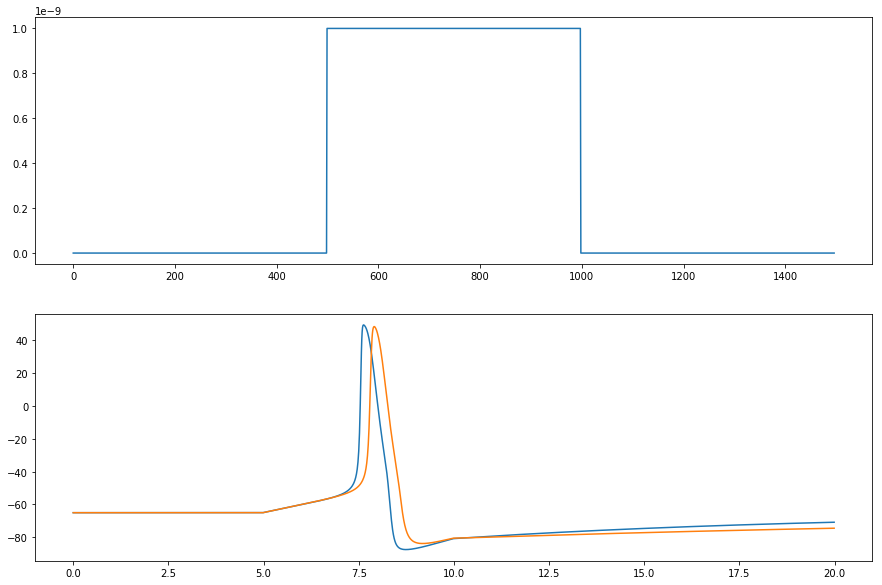

In [33]:
fig, ax = plt.subplots(nrows=2, figsize=(15,10))
ax[0].plot(input_current)
ax[1].plot(np.arange(len(voltage))*dt/ms, voltage);
ax[1].plot(np.arange(len(voltage1))*dt/ms, voltage1);

## Check For Set Values like with Network 

In [34]:
def set_states(self, values, units=True, format='dict', level=0):
        '''
        Set the state variables of objects in the network.
        Parameters
        ----------
        values : dict
            A dictionary mapping object names to objects of ``format``, setting
            the states of this object.
        units : bool, optional
            Whether the ``values`` include physical units. Defaults to ``True``.
        format : str, optional
            The format of ``values``. Defaults to ``'dict'``
        level : int, optional
            How much higher to go up the stack to _resolve external variables.
            Only relevant when using string expressions to set values.
        See Also
        --------
        Group.set_states
        '''
        # For the moment, 'dict' is the only supported format -- later this will
        # be made into an extensible system, see github issue #306
        for obj_name, obj_values in values.items():
            if obj_name not in self:
                raise KeyError(("Network does not include a network with "
                                "name '%s'.") % obj_name)
            self[obj_name].set_states(obj_values, units=units, format=format,
                                     level=level+1)
